In [1]:
import peptide_anisotropy as pa

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import scipy.optimize
import pandas as pd
import scipy.stats, scipy.odr


import re

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Nomenclature
Peptides with enrichment from the phage display experiment used for binding studies


In [2]:
anisotropy_peptides = {"phage_ctl_0":"EGLDLMSILELI",
                       "phage_ctl_1":"RHGFLQDILFKL",
                       "phage_ctl_2":"GWLEQYFSRTAD",
                       "phage_ctl_4":"SRQTTSTHEWVV",
                       "phage_ctl_5":"EQPLLKYLQLMR",
                       "phage_ctl_6":"HVQWRDRNVIEW",
                       "phage_ctl_7":"GEVTNYGYLVDQ",
                       "phage_ctl_8":"SSSTYPGFRQST",
                       "phage_ctl_9":"SGPSDWLHKGVL"}

## Fig S6A,B: Determine probe affinity

Measure FA for labeled 'cacon' probe peptide with increasing [protein] to measure affinity of protein for probe. Do this in both the presence and absence of calcium to verify binding is calcium dependent.  Put in human S100A9 as a negative control, as this protein is evolutionarily distant and is not expected to bind go the cacon peptide. 

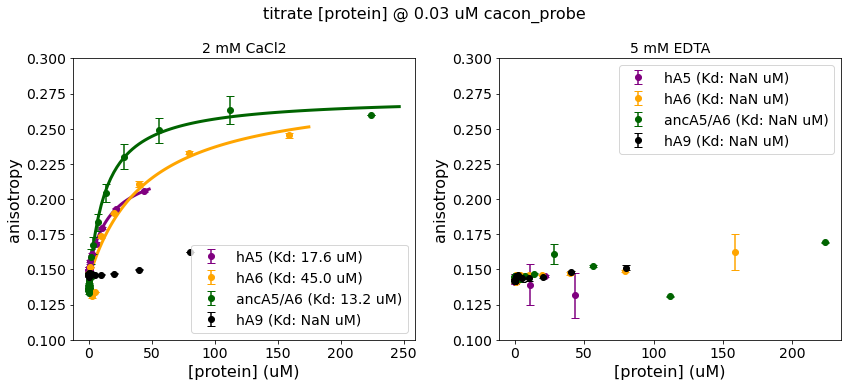

In [3]:
# Load in the experimental data, averaging technical replicates.

df, _ = pa.read_file("02_plate-output.txt","02_plate-layout.xlsx") #,custom_g_plate="custom-g-factor.xlsx")

aA5A6_probe = pa.average_tech_reps(df[np.logical_and(df.protein == "aA5A6",
                                                     df.peptide == "cacon_probe")])

df, _ = pa.read_file("01_plate-output.txt","01_plate-layout.xlsx") #,custom_g_plate="custom-g-factor.xlsx")
aA5A6_edta = pa.average_tech_reps(df[np.logical_and(df.protein == "aA5A6",
                                                    df.peptide == "cacon_probe_edta")])

hA5_probe = pa.average_tech_reps(df[np.logical_and(df.protein == "hA5",
                                                   df.peptide == "cacon_probe")])
hA5_edta = pa.average_tech_reps(df[np.logical_and(df.protein == "hA5",
                                                  df.peptide == "cacon_probe_edta")])

hA6_probe = pa.average_tech_reps(df[np.logical_and(df.protein == "hA6",
                                                   df.peptide == "cacon_probe")])
hA6_edta = pa.average_tech_reps(df[np.logical_and(df.protein == "hA6",
                                                   df.peptide == "cacon_probe_edta")])
               
hA9_probe = pa.average_tech_reps(df[np.logical_and(df.protein == "hA9",
                                                   df.peptide == "cacon_probe")])
hA9_edta = pa.average_tech_reps(df[np.logical_and(df.protein == "hA9",
                                                   df.peptide == "cacon_probe_edta")])

# Generate plots
fig, axes = plt.subplots(1,2,figsize=(12,5.5))

_, _, probe_fit = pa.fit_and_plot([hA5_probe,hA6_probe,aA5A6_probe,hA9_probe],
                                     color_list=["purple","orange","darkgreen","black"],
                                     name_list=["hA5","hA6","ancA5/A6","hA9"],
                                     ylim=(0.1,0.3),title="2 mM CaCl2",
                                     xlabel="[protein] (uM)",log=False,#xlim=(0,100),
                                     fig=fig,ax=axes[0])

_, _, edta_fit = pa.fit_and_plot([hA5_edta,hA6_edta,aA5A6_edta,hA9_edta],
                                    color_list=["purple","orange","darkgreen","black"],
                                    name_list=["hA5","hA6","ancA5/A6","hA9"],
                                    ylim=(0.1,0.3),keep_fit=False,title="5 mM EDTA",
                                    xlabel="[protein] (uM)",log=False,#xlim=(0,100),
                                    fig=fig,ax=axes[1])

fig.suptitle("titrate [protein] @ 0.03 uM cacon_probe",fontsize=16)
plt.tight_layout()
fig.subplots_adjust(top=0.85)


fig.savefig("fig_s6ab.pdf")


# Extract fit information (Kd and predicted change in anisotropy)
hA5_probe_Kd = probe_fit[0][0]*1e6 # uM
hA5_delta_anisotropy = probe_fit[0][2]

hA6_probe_Kd = probe_fit[1][0]*1e6 # uM
hA6_delta_anisotropy = probe_fit[1][2]

aA5A6_probe_Kd = probe_fit[2][0]*1e6 # uM
aA5A6_delta_anisotropy = probe_fit[2][2]


## Load data

Load the fluorescence anisotropy data in from the plate reader output.  For each sample, record the protein concentration, the probe concentration, the probe Kd for the protein (determined above), and how much we predict anisotropy can change given the total change in anisotropy for the probe binding to this protein.  The "plate layout" holds which samples correspond to what positions on the plates correspond to what samples.

In [4]:
df = pa.load_data(  [{"protein":"hA6",
                      "name_in_file":"hA6_4.3",
                      "Kd":hA6_probe_Kd,
                      "max_dA":hA6_delta_anisotropy,
                      "prot_conc":4.2,
                      "probe_conc":4.2,
                      "data_file":"03_plate-output.txt",
                      "plate_file":"03_plate-layout.xlsx",
                      "custom_g_plate":"custom-g-factor.xlsx"},
                     {"protein":"hA6",
                      "name_in_file":"hA6_3.8",
                      "Kd":hA6_probe_Kd,
                      "max_dA":hA6_delta_anisotropy,
                      "prot_conc":3.6,
                      "probe_conc":3.6,
                      "data_file":"03_plate-output.txt",
                      "plate_file":"03_plate-layout.xlsx",
                      "custom_g_plate":"custom-g-factor.xlsx"},
                     {"protein":"hA5",
                      "name_in_file":"hA5",
                      "Kd":hA5_probe_Kd,
                      "max_dA":hA5_delta_anisotropy,
                      "prot_conc":2.7,
                      "probe_conc":3.0,
                      "data_file":"03_plate-output.txt",
                      "plate_file":"03_plate-layout.xlsx",
                      "custom_g_plate":"custom-g-factor.xlsx"},
                     {"protein":"hA5",
                      "name_in_file":"hA5",
                      "Kd":hA5_probe_Kd,
                      "max_dA":hA5_delta_anisotropy,
                      "prot_conc":2.4,
                      "probe_conc":2.4,
                      "data_file":"00_plate-output.txt",
                      "plate_file":"00_plate-layout.xlsx",
                      "custom_g_plate":"custom-g-factor.xlsx"},
                     {"protein":"aA5A6",
                      "name_in_file":"aA5A6",
                      "Kd":aA5A6_probe_Kd,
                      "max_dA":aA5A6_delta_anisotropy,
                      "prot_conc":2.3,
                      "probe_conc":2.3,
                      "data_file":"03_plate-output.txt",
                      "plate_file":"03_plate-layout.xlsx",
                      "custom_g_plate":"custom-g-factor.xlsx"},
                     {"protein":"aA5A6",
                      "name_in_file":"aA5A6",
                      "Kd":aA5A6_probe_Kd,
                      "max_dA":aA5A6_delta_anisotropy,
                      "prot_conc":2.5,
                      "probe_conc":2.5,
                      "data_file":"00_plate-output.txt",
                      "plate_file":"00_plate-layout.xlsx",
                      "custom_g_plate":"custom-g-factor.xlsx"}])

df

,protein,peptide,plate,plate_row,plate_column,conc,r,r_err,weight,outlier_removed,rep_number,Kd_scalar,plate_file,data_file,name_in_file,plate_number,prot_conc,probe_conc,probe_Kd,max_dA
0,hA6,A5cons,1,A,"[7, 8, 9]",9.375000e-08,0.155994,0.000724,1.0,False,1,1.175461,03_plate-layout.xlsx,03_plate-output.txt,hA6_4.3,1,4.2,4.2,45.034048,0.135660
1,hA6,A5cons,1,B,"[7, 8, 9]",1.875000e-07,0.155976,0.000955,1.0,False,1,1.175461,03_plate-layout.xlsx,03_plate-output.txt,hA6_4.3,1,4.2,4.2,45.034048,0.135660
2,hA6,A5cons,1,C,"[7, 8, 9]",3.750000e-07,0.156340,0.000552,1.0,False,1,1.175461,03_plate-layout.xlsx,03_plate-output.txt,hA6_4.3,1,4.2,4.2,45.034048,0.135660
3,hA6,A5cons,1,D,"[7, 8, 9]",7.500000e-07,0.156537,0.000357,1.0,False,1,1.175461,03_plate-layout.xlsx,03_plate-output.txt,hA6_4.3,1,4.2,4.2,45.034048,0.135660
4,hA6,A5cons,1,E,"[7, 8, 9]",1.500000e-06,0.155703,0.000643,1.0,False,1,1.175461,03_plate-layout.xlsx,03_plate-output.txt,hA6_4.3,1,4.2,4.2,45.034048,0.135660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,aA5A6,phage_ctl_9,15,H,"[7, 8, 9]",1.250000e-05,0.163255,0.000190,1.0,False,1,1.339991,00_plate-layout.xlsx,00_plate-output.txt,aA5A6,15,2.5,2.5,13.157726,0.134524
8,aA5A6,phage_ctl_9,15,A,"[10, 11, 12]",2.500000e-05,0.165970,0.001240,1.0,False,1,1.339991,00_plate-layout.xlsx,00_plate-output.txt,aA5A6,15,2.5,2.5,13.157726,0.134524
9,aA5A6,phage_ctl_9,15,B,"[10, 11, 12]",5.000000e-05,0.164882,0.000437,1.0,False,1,1.339991,00_plate-layout.xlsx,00_plate-output.txt,aA5A6,15,2.5,2.5,13.157726,0.134524
10,aA5A6,phage_ctl_9,15,C,"[10, 11, 12]",1.000000e-04,0.163369,0.000624,1.0,False,1,1.339991,00_plate-layout.xlsx,00_plate-output.txt,aA5A6,15,2.5,2.5,13.157726,0.134524


## Fig 3A: Measure affinity of unlabeled phage display competitor peptide by competition with the labeled peptide

/Users/harmsm/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/harmsm/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/harmsm/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

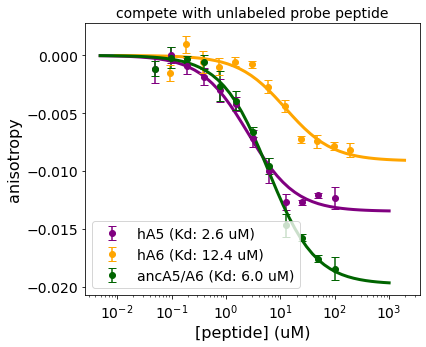

In [5]:

# Grab slices from data frame containing data
hA5_A6cons = df[np.logical_and(df.protein == "hA5",df.peptide == "A6cons")]
hA6_A6cons = df[np.logical_and(df.protein == "hA6",df.peptide == "A6cons")]
aA5A6_A6cons = df[np.logical_and(df.protein == "aA5A6",df.peptide == "A6cons")]

# Offset so we are looking at change an anisotropy
A6cons = [hA5_A6cons,hA6_A6cons,aA5A6_A6cons]
for i in range(len(A6cons)):
    ref_value = np.float(A6cons[i].loc[:,"r"].iloc[1])
    r_values = np.array(A6cons[i].loc[:,"r"],dtype=np.float)
    A6cons[i].loc[:,"r"] = r_values - ref_value


fig, ax = plt.subplots(figsize=(6,5))

_, _, A6cons_fit = pa.fit_and_plot(A6cons,
                                 color_list=["purple","orange","darkgreen"],
                                 name_list=["hA5","hA6","ancA5/A6"],
                                 xlim=None,ylim=None,title="compete with unlabeled probe peptide",
                                 log=True,Kd_guess=1e-6,fig=fig,ax=ax,
                                 required_change_in_signal=None,
                                 offset_to_reference=True)

fig.savefig("fig_3a.pdf")

## Fig S7, S8, S9
Raw fits for hA5, hA6, and aA5/A6

/Users/harmsm/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/harmsm/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/harmsm/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

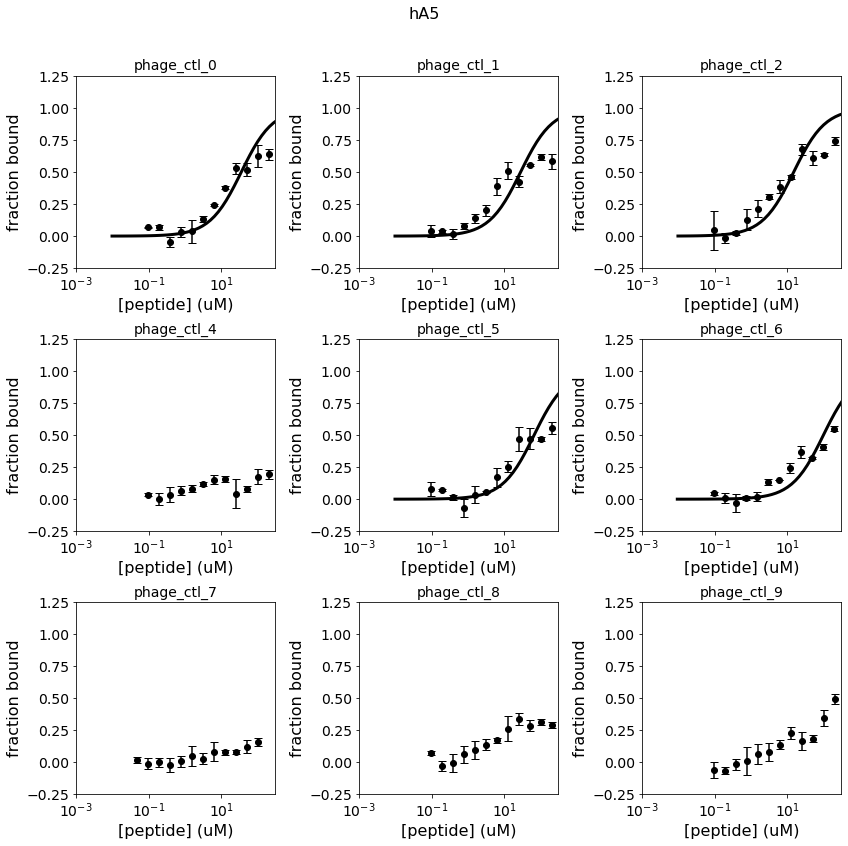

/Users/harmsm/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/harmsm/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/harmsm/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

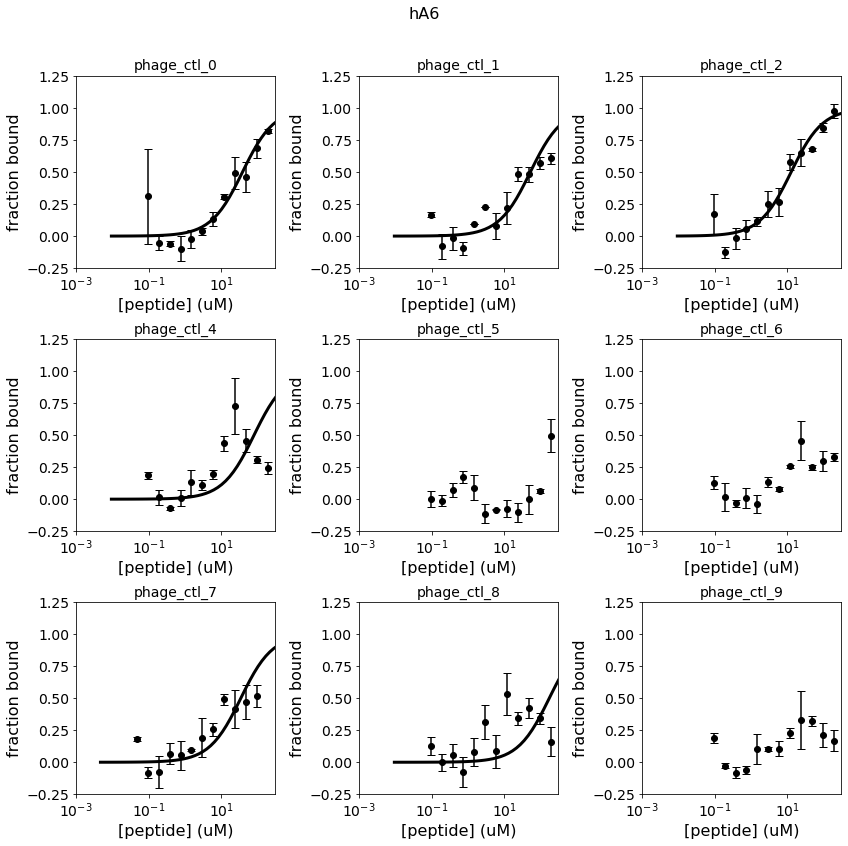

/Users/harmsm/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/harmsm/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/harmsm/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

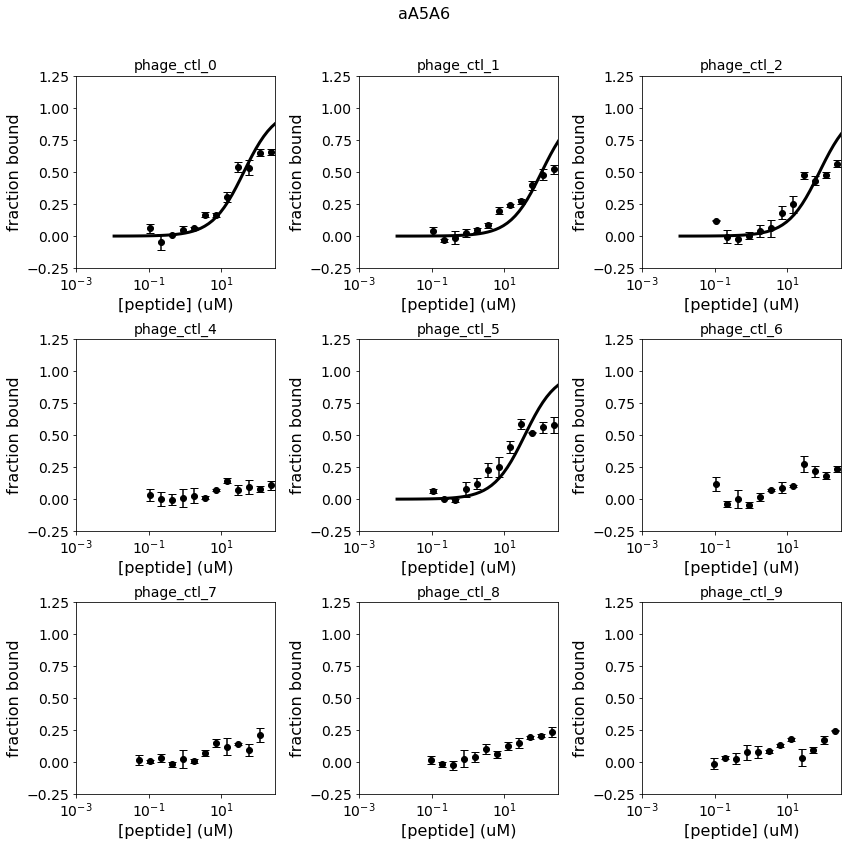

In [6]:

def plot_and_summarize_protein(df,protein,
                               phage_peptides,
                               required_change_in_signal=None,
                               fig_file=None,ref_peptide="phage_ctl_2"):

    fit_dict = {}
    all_colors = ["black","red","blue","orange","darkgreen"]

    prot_df = df[df.protein == protein]
    
    row = 0
    column = 0
    fig, axes = plt.subplots(3,3,figsize=(12,12))
    
    try:
        fit_dict[protein]
    except KeyError:
        fit_dict[protein] = {}

    # Get the fully saturated and fully unsaturated baselines from a reference
    # peptide.  
    baselines = []
    ref_df = prot_df[prot_df.peptide == ref_peptide]
    for i, rep in enumerate(np.unique(ref_df.rep_number)):
        rep_df = ref_df[ref_df.rep_number == rep]
        df_list = [rep_df]
        _, _, fit = pa.fit_and_plot(df_list,plot=False,offset_to_reference=True)
        
        baselines.append((0,fit[0][2]))

    # Go through data and find "0" baseline for each peptide. 
    for peptide in phage_peptides:
        pep_df = prot_df[prot_df.peptide == peptide]
    
        df_list = []
        name_list = []
        color_list = []
        scalar_list = []
        baseline_list = []
        do_fit_list = []
        for i, rep in enumerate(np.unique(pep_df.rep_number)):
            
            rep_df = pep_df[pep_df.rep_number == rep]
            
            # Offset rep_df so 0 competitor baseline is 0
            _, _, fit = pa.fit_and_plot([rep_df],plot=False,offset_to_reference=False)
            if np.isnan(fit[0][1]):
                offset = np.mean(rep_df.r.iloc[:1])
            else:
                offset = fit[0][1]
            
            rep_df.loc[:,"r"] = rep_df.loc[:,"r"] - offset
            
            # HACK!  DID EXTRA REPS ON SAME DAY FOR A FEW PEPTIDES.  THIS GETS
            # THE RIGHT BASELINE, BUT JUST BY TAKING THE LAST BASELINE IN THE
            # STACK. 
            try:
                baseline = baselines[i]
            except IndexError:
                baseline = baselines[-1]
            
            prot_conc = rep_df.prot_conc.iloc[0]
            probe_conc = rep_df.probe_conc.iloc[0]
            probe_Kd = rep_df.probe_Kd.iloc[0]

            # This is the expected change in anisotropy fiven concentrations and probe Kd.
            # Note that I assert that all proteins give *total* change in anisotropy of 0.135. 
            M,X,MX = pa.species(prot_conc,probe_conc,probe_Kd)
            fx_max = MX/probe_conc*0.135 
            
            # Convert rep_df to go from 0 to 1           
            #print(-(rep_df.loc[:,'r'] - baseline[0])/0.013)
            rep_df.loc[:,"r"] = -(rep_df.loc[:,"r"] - baseline[0])/fx_max
            rep_df.loc[:,"r_err"] = np.abs(-(rep_df.loc[:,"r_err"] - baseline[0])/fx_max)
            
            # Record new ref_df, name, color, Kd_peptide_scalar, and baselines
            df_list.append(rep_df)
            name_list.append(f"{rep}")
            color_list.append(all_colors[i])
            scalar_list.append(rep_df.Kd_scalar.iloc[0])
            baseline_list.append((0,1))
            
            # Figure out if we are doing fit based on max signal change
            do_fit_list.append(True)
            if required_change_in_signal is not None:
                if np.max(rep_df.loc[:,"r"]) < required_change_in_signal:
                    do_fit_list[-1] = False
        
        do_fit = do_fit_list[0]
        
        # Sample to get error
        Kd_list = []
        for i in range(10):
            df_list_sampled = []
            for j in range(len(df_list)):
                d = df_list[j].copy()
                d.r = np.random.normal(d.r,d.r_err)
                df_list_sampled.append(d)
            
            _, _, fit = pa.fit_and_plot(df_list_sampled,
                                        baseline_list=baseline_list,
                                        offset_to_reference=False,
                                        plot=False)
                                        #   #required_change_in_signal=required_change_in_signal,
                                        #  color_list=color_list,
                                        #  name_list=name_list,
                                        #  xlim=(0.001,300),ylim=(-0.25,1.25),
                                        #  log=True,Kd_guess=1e-6,
                                        #  fig=fig,ax=axes[row,column],
                                        #  ylabel="fraction bound",
                                        #  alpha=0.1,legend=False,plot_err=False)
            
            Kd_list.extend([f[0]*scalar_list[j] for j, f in enumerate(fit)])
        
        
        # ML FIT for first rep for visualization purposes
        fig, ax, fit = pa.fit_and_plot([df_list[0]],
                                baseline_list=[baseline_list[0]],
                                offset_to_reference=False,
                                color_list=[color_list[0]],
                                  name_list=[name_list[0]],
                                  xlim=(0.001,300),ylim=(-0.25,1.25),
                                  log=True,Kd_guess=1e-6,
                                  fig=fig,ax=axes[row,column],
                                  ylabel="fraction bound",
                                  alpha=1.0,legend=False,
                                  keep_fit=do_fit)

        try:
            fit_dict[protein][peptide]
        except KeyError:
            fit_dict[protein][peptide] = []

        
        if not do_fit:
            fit_dict[protein][peptide].extend([1])
        else:
            # Record Kd, with Kd_peptide_scalar appropriate for experimental conditions
            fit_dict[protein][peptide].extend(Kd_list)

        axes[row,column].set_title("{}".format(peptide))

        column += 1
        if column > 2:
            column = 0
            row += 1


    fig.suptitle(f"{protein}",fontsize=16)
    plt.tight_layout()
    fig.subplots_adjust(top=0.90)
    
    if fig_file is not None:
        plt.savefig(f"{protein}.pdf")
        
    plt.show()

    return fit_dict
    

# Remove phage_ctl_3 (never arrived, never tested)
phage_peptides = [f"phage_ctl_{i}" for i in range(10)]
phage_peptides.remove("phage_ctl_3")

fit_dict = {}
filtered_df = df.copy()

fit_results = plot_and_summarize_protein(filtered_df,"hA5",phage_peptides,
                                         required_change_in_signal=0.5,
                                         fig_file="fig_s7.pdf")
fit_dict["hA5"] = fit_results["hA5"]

fit_results = plot_and_summarize_protein(filtered_df,"hA6",phage_peptides,
                                         required_change_in_signal=0.5,
                                         fig_file="fig_s8.pdf")
fit_dict["hA6"] = fit_results["hA6"]

fit_results = plot_and_summarize_protein(filtered_df,"aA5A6",phage_peptides,
                                         required_change_in_signal=0.5,
                                         ref_peptide="phage_ctl_2",
                                         fig_file="fig_s9.pdf")
fit_dict["aA5A6"] = fit_results["aA5A6"]


## Load other experimental data

In [7]:

enrichment_df = pd.read_csv("../fig_2cd-s3-s4-s5/hA5-hA6-aA5A6_enrichment_pooled.txt")
mask = [s in anisotropy_peptides.values() for s in enrichment_df.seq]
enrich = enrichment_df[mask]

names = []
seq_to_name = dict([(anisotropy_peptides[k],k) for k in anisotropy_peptides.keys()])
for seq in enrich.seq:
    names.append(seq_to_name[seq])
    
enrich.loc[:,"name"] = names

enrich_dict = {}
for i in range(len(enrich)):
    peptide = enrich.name.iloc[i]
    try:
        enrich_dict[peptide]
    except KeyError:
        enrich_dict[peptide] = {}
    
    enrich_dict[peptide]["hA5"] = enrich.iloc[i].hA5
    enrich_dict[peptide]["hA6"] = enrich.iloc[i].hA6
    enrich_dict[peptide]["aA5A6"] = enrich.iloc[i].aA5A6

out_dict = {"protein":[],
            "peptide":[],
            "Kd":[],
            "dG_mean":[],
            "dG_err":[],
            "E":[]}

prot_list = ["hA5","hA6","aA5A6"]

for prot in prot_list: 
    
    for pep in fit_dict[prot].keys():
        
        try:
            Kd = fit_dict[prot][pep]
        except KeyError:
            continue
                
        dG = -0.001987*(273.15 + 27)*np.log(np.array(Kd))
        dG_mean = np.nanmean(dG)
        dG_err = 1.96*np.nanstd(dG)
            
        try:
            E = enrich_dict[pep][prot]
        except KeyError:
            E = np.nan
        
        if np.isnan(dG_mean):
            dG_mean = 0

        out_dict["protein"].append(prot)
        out_dict["peptide"].append(pep)
        out_dict["Kd"].append(Kd)
        out_dict["dG_mean"].append(dG_mean)
        out_dict["dG_err"].append(dG_err)
        out_dict["E"].append(E)
        
        
out_df = pd.DataFrame(out_dict)
out_df


/Users/harmsm/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/harmsm/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,protein,peptide,Kd,dG_mean,dG_err,E
0,hA5,phage_ctl_0,"[4.396736669545534e-05, 4.979979312311028e-05,...",5.956788,0.119357,-4.264078
1,hA5,phage_ctl_1,"[3.662740093364922e-05, 3.2768800721864e-05, 3...",6.058803,0.172148,-3.575006
2,hA5,phage_ctl_2,"[1.9327741500396914e-05, 1.8980559920706142e-0...",6.484730,0.095569,-4.680616
3,hA5,phage_ctl_4,[1],0.000000,0.000000,-0.718060
4,hA5,phage_ctl_5,"[9.000710961796354e-05, 8.138273369601329e-05,...",5.644965,0.171980,-0.320066
5,hA5,phage_ctl_6,"[0.00012852205473097106, 0.0001312603990724149...",5.357764,0.055474,-0.210314
6,hA5,phage_ctl_7,[1],0.000000,0.000000,-0.156579
7,hA5,phage_ctl_8,[1],0.000000,0.000000,-0.402596
8,hA5,phage_ctl_9,[1],0.000000,0.000000,0.588192
9,hA6,phage_ctl_0,"[4.010415811502083e-05, 4.4887596058190556e-05...",5.979548,0.158608,-4.675493


## Fig 3C: correlation between dG and E

Beta: [-0.35082792  4.14382218]
Beta Std Error: [0.36690712 1.59500898]
Beta Covariance: [[0.05640507 0.24111749]
 [0.24111749 1.06593854]]
Residual Variance: 2.3866794840124945
Inverse Condition #: 0.004105673939043558
Reason(s) for Halting:
  Sum of squares convergence


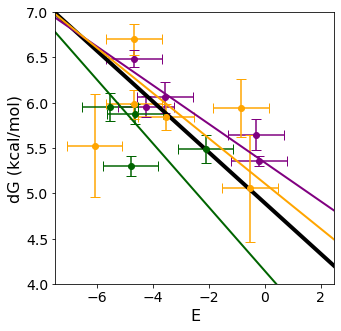

In [8]:

fig, ax = plt.subplots(figsize=(5,5))

color_list = ["purple","orange","darkgreen"]
for i, prot in enumerate(["hA5","hA6","aA5A6"]):
    
    prot_df = out_df[out_df.protein == prot]
    ax.errorbar(prot_df.E,prot_df.dG_mean,prot_df.dG_err,1,fmt="o",capsize=5,color=color_list[i])


def run_odr(x,y,x_err,y_err):
    """
    Fit a linear model to x,y data using orthoganol distance regression. 
    x, y: x and y data as arrays
    returns slow, intercept, variance explained
    """

    model = scipy.odr.Model(lambda B, x: B[0]*x + B[1])
    data = scipy.odr.RealData(x,y,x_err,y_err)
    fitter = scipy.odr.ODR(data, model, beta0=[1., 0.])
    fit = fitter.run()
    return fit.beta[0], fit.beta[1], fit

fit_df = out_df[out_df.dG_mean > 0]


m, b, fit = run_odr(fit_df.E,fit_df.dG_mean,[1 for _ in range(len(fit_df.E))],fit_df.dG_err)
ax.plot((-7.5,2.5),m*np.array((-7.5,2.5)) + b,"-",color="black",lw=4)


color_list = ["purple","orange","darkgreen"]
protein_list = ["hA5","hA6","aA5A6"]
for i in range(3):

    prot = protein_list[i]
    col = color_list[i]
    
    m, b, fit = run_odr(fit_df.E[fit_df.protein == prot],
                        fit_df.dG_mean[fit_df.protein == prot],
                        [1 for _ in range(len(fit_df.E[fit_df.protein == prot]))],
                        fit_df.dG_err[fit_df.protein == prot])
    ax.plot((-7.5,2.5),m*np.array((-7.5,2.5)) + b,"-",color=col,lw=2)


ax.set_ylim(4,7)
ax.set_xlim((-7.5,2.5))
ax.set_xlabel("E")
ax.set_ylabel("dG (kcal/mol)")

plt.savefig("fig_3c.pdf")


fit.pprint()

## Fig 3C (binomial bit)

In [9]:

# Grab fits that failed
x_df = out_df[out_df.dG_mean == 0]

# Get classes for fits (above or below cutoff)
below = x_df.dG_mean[x_df.E < -1.5]
above = x_df.dG_mean[x_df.E >= -1.5]

# Determine the probability of being below the cutoff given the composition
# of the data set
num_low = np.sum(out_df.E < -1.5)
num_high = np.sum(out_df.E >= -1.5)
p_low = num_low/(num_low + num_high)

# Cumulative probability we see this number below the threshold given binomial
# distribution
p_value = np.sum(scipy.stats.binom.pmf(range(len(below) + 1),len(below) + len(above),p_low))
print(len(below),len(above),p_value)


2 10 0.026082028133109753
